In [ ]:
# tracks={}
# for no in ['A','B','C','D']:
#     tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [ ]:
import pandas_profiling as pdp

In [3]:
summarys4 = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4[no] = pd.read_csv(f'summary4_{no}.csv', index_col=0)

In [2]:
for no in ['A', 'B', 'C', 'D']:
    summarys4[no].loc[summarys4[no]['傾き'] == -100, '傾き'] = np.median(summarys4[no].loc[summarys4[no]['傾き'].notnull(), '傾き'])
    summarys4[no].loc[summarys4[no]['傾き'].isnull(), '傾き'] = np.median(summarys4[no].loc[summarys4[no]['傾き'].notnull(), '傾き'])
    summarys4[no].loc[summarys4[no]['切片'].isnull(), '切片'] = np.median(summarys4[no].loc[summarys4[no]['切片'].notnull(), '切片'])

In [ ]:
from fbprophet import Prophet

In [ ]:
summarys4['A'].dropna()

In [ ]:
import datetime

In [ ]:
[i for i in range(0, len(summary), 10)]

In [ ]:
data = pd.DataFrame(columns=['ds', 'y'])
# summary = summarys4['A'].dropna().loc[10000:10200, '切片'].values
summary = summarys4['A'].loc[10000:10200, '切片'].values
# summary = summarys4['A'].dropna()

data['ds'] = [datetime.datetime(1900, 1, 1) + datetime.timedelta(days=i) for i in range(len(summary))]
data['y'] = summary
# data['ds'] = [datetime.date(1900, 1, 1) + datetime.timedelta(days=i) for i in range(0, len(summary)*100, 100)]
# data['y'] = summary*100
model = Prophet()
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(data)

In [ ]:
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [ ]:
model.plot_components(forecast)
plt.show()

In [ ]:
# add change rates to changepoints
df_changepoints = data.loc[model.changepoints.index]
df_changepoints['delta'] = model.params['delta'].ravel()

# get changepoints
df_changepoints['ds'] = df_changepoints['ds'].astype(str)
df_selection = df_changepoints[df_changepoints['delta'] != 0]
date_changepoints = df_selection['ds'].astype('datetime64[ns]').reset_index(drop=True)

# plot
sns.set(style='whitegrid')
ax = sns.factorplot(x='ds', y='delta', data=df_changepoints, kind='bar', color='royalblue', size=4, aspect=2)
ax.set_xticklabels(rotation=90)

In [ ]:
import statsmodels.api as sm

data = pd.DataFrame(columns=['ds', 'y'])
summary = summarys4['A'].loc[10000:10200, '切片'].values

data['ds'] = [datetime.datetime(2000, 1, 1) + datetime.timedelta(days=i) for i in range(len(summary))]
data['y'] = summary

# res = sm.tsa.seasonal_decompose(data)
res = sm.tsa.seasonal_decompose(summary, freq=10)
res.plot()

In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
def make_dataset(low_data):

    data, target = [], []
#     maxlen = 25
    maxlen = 50

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [7]:
# summary = summarys4['A'].loc[0:1000, '切片'].values
summary = summarys4['A'].loc[10000:10500, '傾き'].values

# normalize the dataset
scaler = MinMaxScaler()
summary = scaler.fit_transform([[i] for i in summary])

#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(summary)

In [35]:
# モデル構築

# 1つの学習データのStep数(maxlen)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 20

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
# optimizer = Adam(lr=0.0001)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
model.compile(loss="mean_squared_error", optimizer='adam')

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
model.fit(g, h,
          batch_size=1,
          epochs=50,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Train on 405 samples, validate on 46 samples
Epoch 1/50
405/405 [==============================] - 19s 46ms/step - loss: 0.0298 - val_loss: 0.0028
Epoch 2/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0101 - val_loss: 0.0027
Epoch 3/50
405/405 [==============================] - 18s 44ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 4/50
405/405 [==============================] - 18s 45ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 5/50
405/405 [==============================] - 17s 41ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 6/50
405/405 [==============================] - 16s 40ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 7/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 8/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 9/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 10/50
405/405 [================

In [37]:
# 予測
predicted = model.predict(g)

<Figure size 1440x576 with 0 Axes>

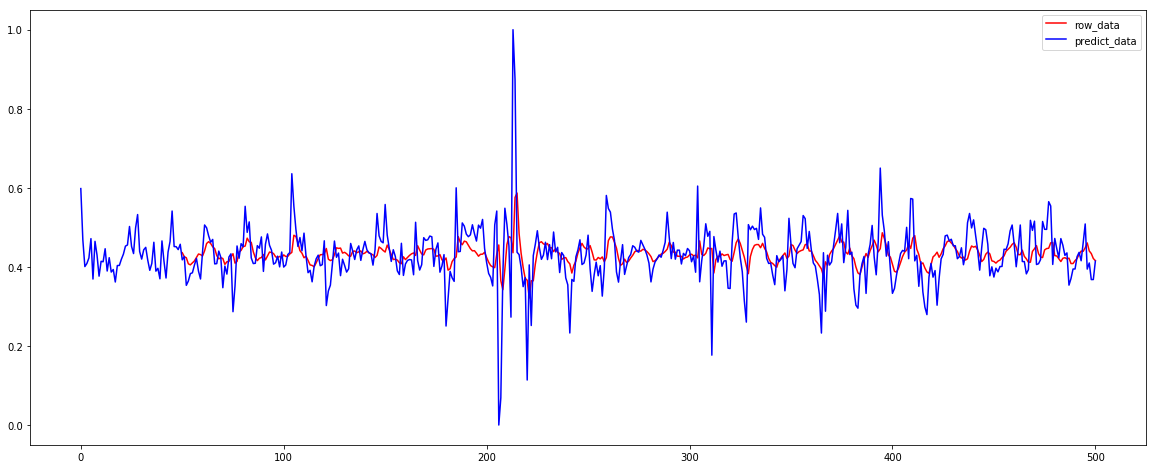

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(range(50,len(predicted)+50), predicted, color="r", label="row_data")
plt.plot(range(0, len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

In [92]:
num=3.0
b = np.ones(int(num))/num
ma = np.convolve(summary.reshape(len(summary)), b, mode='same')

<Figure size 8640x2160 with 0 Axes>

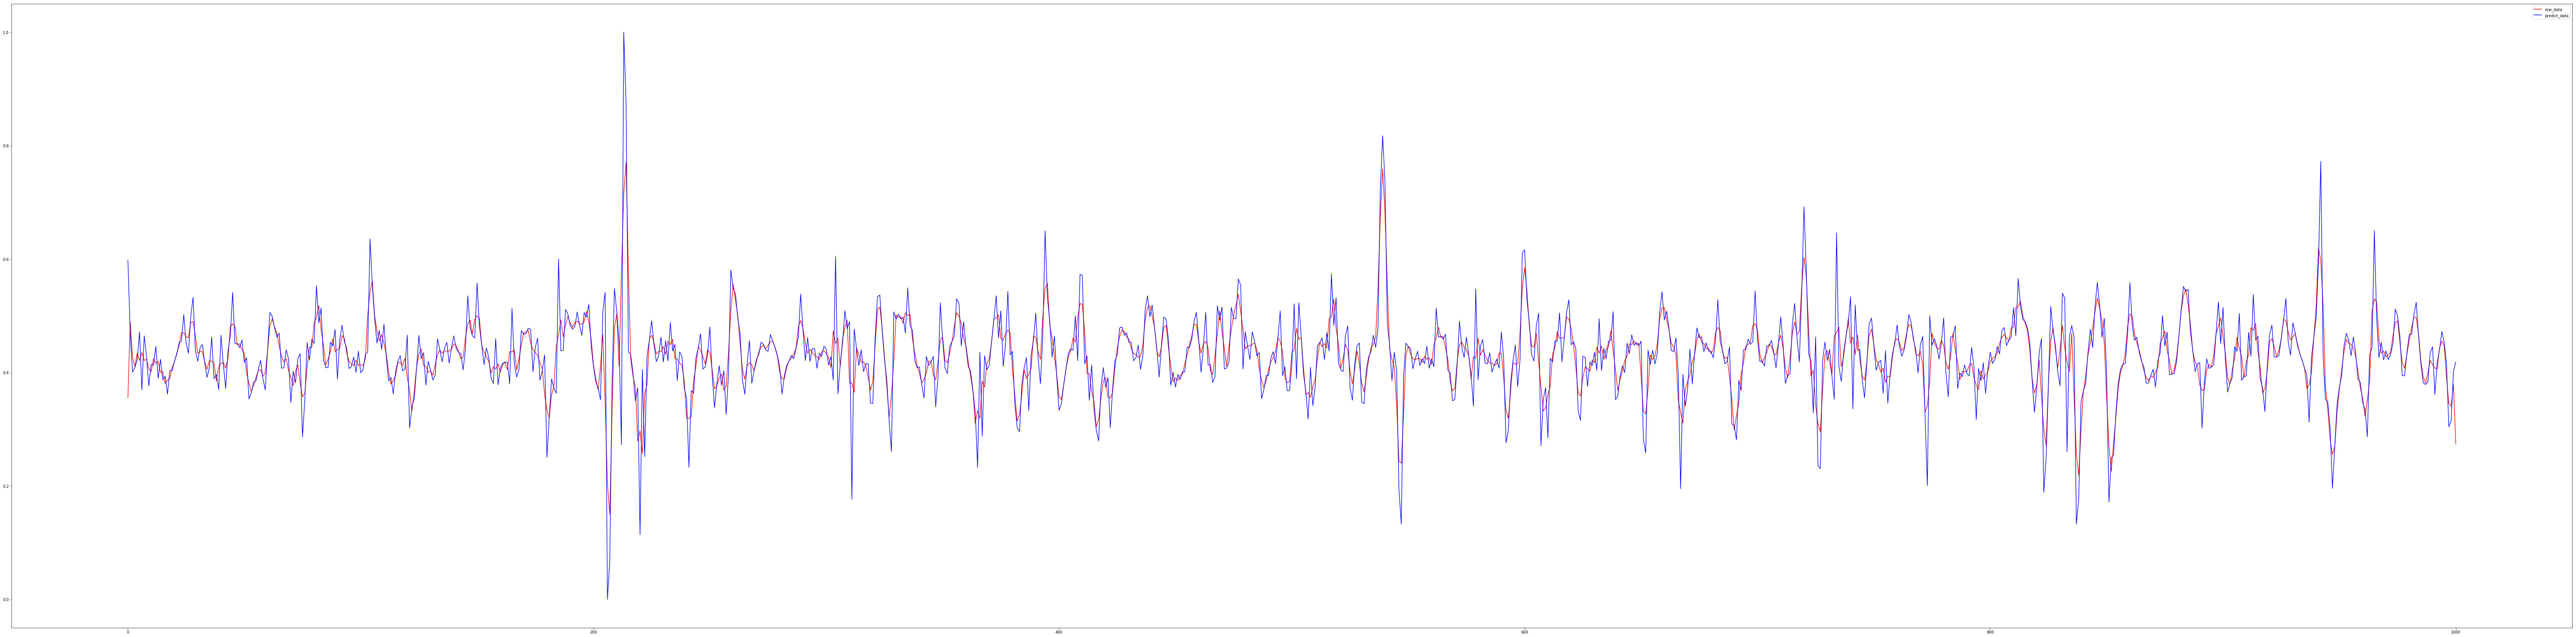

In [94]:
plt.figure(figsize=(120, 30))
plt.plot(range(len(summary)), ma, color="r", label="row_data")
plt.plot(range(len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()